In [2]:
import cv2
import numpy as np
import pickle
import random
import copy
import pandas as pd
import os


# Generate Datasets

In [3]:
def read_image(img_path, show=False):
    """
    # Function
    Read image into numpy array
    # Parameter
    img_path: string
        full path of an image
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)# return a object
    if not img.dtype == np.uint8:
        pass

    if show:
        show_image(img)
    
    return img

In [4]:
def img2data_img(path, dic):
    """
    # Function
    Create a dictionary whose keys are all image names, values are image matrix
    # Parameters
    path: string
        path of the directory that contains images
    dic: dictionary
        input dictionrary to which will be added image matrix
    """
    for file in os.listdir(path):
        fullpath=path+file
        file_split=file.split(".")
        ext=file_split[1]
        img_name=file_split[0]
        if ext=="png":
            img=read_image(fullpath)
            if img_name in dic:
                print("same file name")
            else:
                dic[img_name]=[img]
    return dic

In [5]:
def pair_img(df, dic, shuffle=False):
    """
    # Function
    Create pairs of data that can fit into Siamese network
    # Parameters
    df: DataFrame
        the seen, unseen or shuffle dataset
    dic: dictionray
        the dictionary that contains all the image matrix
    """
    if shuffle:
        df=df.sample(frac=1)
    arr=np.array(df[["left","right","label"]])
    pair=[]
    label=[]
    for i in range(arr.shape[0]):
        row=arr[i,:]
        left_name=row[0].split('.')[0]
        right_name=row[1].split('.')[0]
        if (left_name not in dic) or (right_name not in dic):
            continue
        left=np.expand_dims(dic[left_name][0],axis=2) # left img 
        right=np.expand_dims(dic[right_name][0],axis=2) # right img 
        pair.append([left,right])# concatenate the left and right image matrix
        label.append(row[2])
    return np.array(pair,dtype="double"),np.array(label,dtype="double")

In [2]:
cwd = os.getcwd()
data_dic={}
impath=cwd+"/seen-dataset/TrainingSet/" # include images in seen dataset
data_dic=img2data_img(impath,data_dic)
impath=cwd+"/seen-dataset/ValidationSet/"
data_dic=img2data_img(impath,data_dic)
impath=cwd+"/unseen-dataset/TrainingSet/"# include images in unseen dataset
data_dic=img2data_img(impath,data_dic)
impath=cwd+"/unseen-dataset/ValidationSet/"
data_dic=img2data_img(impath,data_dic)

In [7]:
"""
Create training and validation dataset from the dictionary
"""
# training data in seen
df_seen_tr=pd.read_csv(cwd+"/seen-dataset/dataset_seen_training_siamese.csv")
pairs_seen_tr, y_seen_tr=pair_img(df_seen_tr, data_dic, shuffle=True)
# validation data in seen
df_seen_va=pd.read_csv(cwd+"/seen-dataset/dataset_seen_validation_siamese.csv")
pairs_seen_va, y_seen_va=pair_img(df_seen_va, data_dic, shuffle=True)
# training data in unseen
df_unseen_tr=pd.read_csv(cwd+"/unseen-dataset/dataset_seen_training_siamese.csv")
pairs_unseen_tr, y_unseen_tr=pair_img(df_unseen_tr, data_dic, shuffle=True)
# validation data in unseen
df_unseen_va=pd.read_csv(cwd+"/unseen-dataset/dataset_seen_validation_siamese.csv")
pairs_unseen_va, y_unseen_va=pair_img(df_unseen_va, data_dic, shuffle=True)
# traning data in shuffled
df_shuffle_tr=pd.read_csv(cwd+"/shuffled-dataset/dataset_seen_training_siamese.csv")
pairs_shuffle_tr, y_shuffle_tr=pair_img(df_shuffle_tr, data_dic)
# validation data in shuffled
df_shuffle_va=pd.read_csv(cwd+"/shuffled-dataset/dataset_seen_validation_siamese.csv")
pairs_shuffle_va, y_shuffle_va=pair_img(df_shuffle_va, data_dic)


In [8]:
"""
The dataset for Siamest network training
"""
# data_dic_writer=img2data(impath)
# tr_dic,va_dic,te_dic=split_data(data_dic_writer,0.8,0.1,0.1)
# tr_pairs, tr_y=sample_pairs(tr_dic)
# va_pairs, va_y=sample_pairs(va_dic)
# print(np.sum(dic_size(tr_dic)),np.sum(dic_size(va_dic)),np.sum(dic_size(te_dic)))

tr_pairs, tr_y=pairs_seen_tr, y_seen_tr
va_pairs, va_y=pairs_seen_va, y_seen_va
print(tr_pairs.shape,va_pairs.shape)

(114390, 2, 64, 64, 1) (906, 2, 64, 64, 1)


# Build Deep Learning Model

In [34]:
from keras.models import Model
from keras.optimizers import Adadelta, SGD, Adam, RMSprop
from keras.layers import Input,Conv2D,MaxPooling2D,BatchNormalization,Activation,Reshape,UpSampling2D,Flatten,Lambda
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [65]:
def create_basenet(imDim):
    input_shape  = (imDim,imDim,1)
    inp_img = Input(shape = (imDim,imDim,1))
    model = inp_img
    model = Conv2D(16,kernel_size=(3, 3),activation='relu',padding='valid')(model)
    model = MaxPooling2D((2,2), padding='valid')(model)
    # second
    model = Conv2D(32, (3, 3), activation='relu',padding='valid')(model)
    model = MaxPooling2D((2,2),padding='valid')(model)
    # third
    model = Conv2D(32, (3, 3), activation='relu',padding='valid')(model)
    model = MaxPooling2D((2,2),padding='valid')(model)
    
    model = Flatten()(model)
    base=Model(inputs=[inp_img], outputs=[model],name = 'base_model')
    return base
def cal_distance(inputs):
    """
    # Parameter
    inputs: list of tensor of left and right process
    """
    x1,x2=inputs
    sumofsquare=K.sum(K.square(x1-x2),axis=1,keepdims=True)
    return K.sqrt(K.maximum(sumofsquare, K.epsilon())) # final output is the eu-distance btw two imgs
def distance_shape(shape):
    s1, s2=shape
    return (s1[0],1)# same shape of s1 and s2
def contrastive_loss(y_true,dist): # input argument (true output, predict output)
    """
    # Parameter
    y_true: numpy array
        true label of verification
    dist: tensor
        eu-distance between two imgages
    """
    margin=0.05
    same=K.square(dist) # 
    diff=K.square(K.maximum(margin-dist,0))
    return y_true*same+(1-y_true)*diff
def accuracy(y_true,dist):
    """
    Create a tensor that is used as accuracy in model training
    """
    th=0.2
    return K.mean(K.equal(y_true, K.cast(dist < th, y_true.dtype)))
def acc_scalar(y_true, dist):
    """
    A scalar accuracy and return a scalar
    """
    th=0.2
    y_pred=(dist<th)*1.0
    y_pred=y_pred.reshape(-1)
    right=np.where(y_pred==y_true)[0].shape[0]
#     print(y_pred.shape, y_true.shape)
#     print(y_true.shape[0],right)
    return right/y_true.shape[0]

In [50]:
"""
Create base network which is shared by left and right image
"""
imDim=64
base_network=create_basenet(imDim)
base_network.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 62, 16)        160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 32)          0         
__________

In [51]:
"""
Create Siamese network, using euclidean distance between two images as output
"""
input_left=Input(shape = (imDim,imDim,1), name = 'left_image') # input layer for left image
input_right=Input(shape = (imDim,imDim,1), name = 'right_image') # input layer for right image
ts_left=base_network(input_left)
ts_right=base_network(input_right)
print(ts_left.shape)
distance=Lambda(cal_distance,output_shape=distance_shape)([ts_left,ts_right])# create a tensor that calcualte the distance
print(distance.shape)
distance=BatchNormalization()(distance)# normalize the distance
model=Model([input_left,input_right],distance)
model.summary()

(?, ?)
(?, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_image (InputLayer)         (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
right_image (InputLayer)        (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
base_model (Model)              (None, 1152)         14048       left_image[0][0]                 
                                                                 right_image[0][0]                
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 1)            0           base_model[1][0]              

In [52]:
tr_pairs.shape, tr_y.shape

((114390, 2, 64, 64, 1), (114390,))

In [53]:
def datagen(batch_size, tr_pairs, tr_y):
    count=0
    num_all=tr_pairs.shape[0]
    arr=np.arange(0,num_all)
    np.random.shuffle(arr)
    start=0
    index_list=[]
    while True:
        if start>=num_all:
            start=0
            np.random.shuffle(arr)
            continue
        end=start+batch_size
        if end>num_all:
            index_list=np.copy(arr[start:])
            start=0
            np.random.shuffle(arr)
        else:
            index_list=np.copy(arr[start:end])
            start=start+batch_size
        yield [tr_pairs[index_list,0],tr_pairs[index_list,1]], tr_y[index_list]
        

In [54]:
tg=datagen(64, tr_pairs, tr_y)
vg=datagen(64, va_pairs, va_y)

In [55]:
mc = ModelCheckpoint(filepath='task3_siamese_seen.h5', monitor='val_loss',period=1,
                     save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=100, monitor='val_loss', min_delta=0.005, mode='auto')

In [3]:
"""
Train model
"""
# early_patience=20
# earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
EPOCHS=2000
INIT_LR=1e-4
opt = Adadelta(lr=INIT_LR, decay=1e-04)
model.compile(loss=contrastive_loss,optimizer=opt,metrics=[accuracy])
# hist=model.fit([tr_pairs[:,0],tr_pairs[:,1]],tr_y,
#                   batch_size=64,epochs=1,
# #                   validation_data=([va_pairs[:,0],va_pairs[:,1]],va_y),
# #                   shuffle=True
#                   validation_split=0.2
#                   )
hist = model.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

In [57]:
df_hist = pd.DataFrame(hist.history)
df_hist.head(10)

val_loss  val_accuracy      loss  accuracy
0  0.373613      0.875000  0.501918  0.671875
1  0.411585      0.890625  0.481576  0.625000
2  0.308300      0.921875  0.549828  0.687500
3  0.495934      0.875000  0.513338  0.734375
4  0.499270      0.937500  0.510572  0.593750
5  0.416712      0.796875  0.613670  0.656250
6  0.620815      0.921875  0.399567  0.578125
7  0.664502      0.890625  0.583722  0.640625
8  0.402716      0.875000  0.468364  0.703125
9  0.654999      0.812500  0.456220  0.640625

0.13801336288452148
1.0


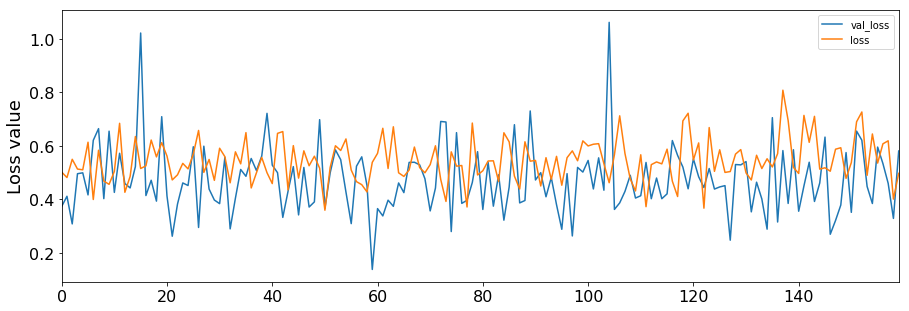

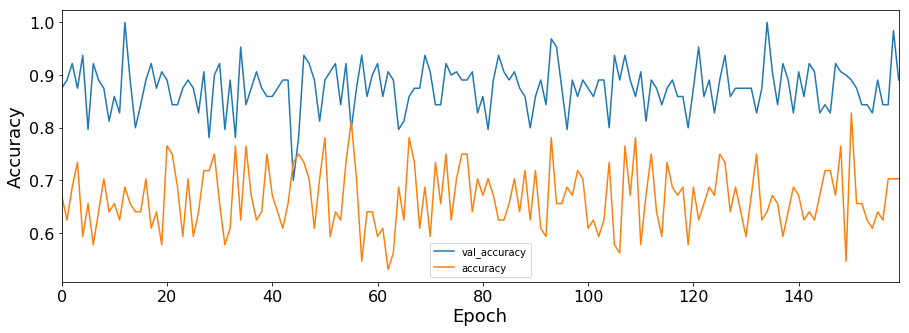

In [84]:

fig_loss=df_hist[["val_loss","loss"]].plot(subplots=False, figsize=(15,5), fontsize=16)
fig_loss.set_ylabel("Loss value", fontsize=18)
fig_acc=df_hist[["val_accuracy","accuracy"]].plot(subplots=False, figsize=(15,5), fontsize=16)
fig_acc.set_xlabel("Epoch", fontsize=18)
fig_acc.set_ylabel("Accuracy", fontsize=18)
print(df_hist['val_loss'].min())
print(df_hist['val_accuracy'].max())

In [60]:
pred_va=model.predict([va_pairs[:,0],va_pairs[:,1]])

In [82]:

print("Validation accuracy: ",acc_scalar(va_y, pred_va))

(906,) (906,)
906 797
Validation accuracy:  0.8796909492273731
